Training Logistic Regression...
Training Random Forest...
Training XGBoost...


c:\Users\hussa\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [09:22:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Logistic Regression Accuracy: 0.8077
              precision    recall  f1-score   support

           0     0.8000    0.7789    0.7893      6938
           1     0.8141    0.8325    0.8232      8067

    accuracy                         0.8077     15005
   macro avg     0.8070    0.8057    0.8062     15005
weighted avg     0.8076    0.8077    0.8075     15005


Random Forest Accuracy: 0.9989
              precision    recall  f1-score   support

           0     0.9984    0.9993    0.9988      6938
           1     0.9994    0.9986    0.9990      8067

    accuracy                         0.9989     15005
   macro avg     0.9989    0.9990    0.9989     15005
weighted avg     0.9989    0.9989    0.9989     15005


XGBoost Accuracy: 0.9109
              precision    recall  f1-score   support

           0     0.9188    0.8856    0.9019      6938
           1     0.9045    0.9327    0.9184      8067

    accuracy                         0.9109     15005
   macro avg     0.9117    0.909

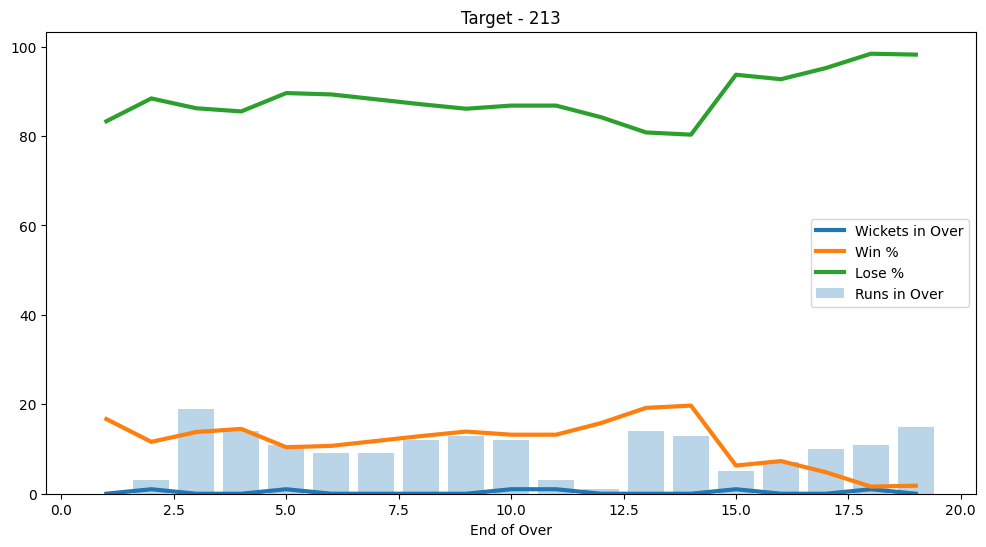

In [2]:
import numpy as np
import pandas as pd

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
match = pd.read_csv('matches.csv')
delivery = pd.read_csv('deliveries.csv')

delivery['total_runs'] = delivery['batsman_runs'] + delivery['extra_runs']
total_score_df = delivery.groupby(['match_id', 'inning'])['total_runs'].sum().reset_index()

total_score_df = total_score_df[total_score_df['inning'] == 1].rename(columns={'total_runs': 'first_innings_total'})

match_df = match.merge(total_score_df[['match_id', 'first_innings_total']],
                       left_on='id', right_on='match_id', how='inner')

match_df['team1'] = match_df['team1'].replace({
    'Delhi Daredevils': 'Delhi Capitals',
    'Deccan Chargers': 'Sunrisers Hyderabad',
    'Gujarat Lions': 'Gujarat Titans'
})
match_df['team2'] = match_df['team2'].replace({
    'Delhi Daredevils': 'Delhi Capitals',
    'Deccan Chargers': 'Sunrisers Hyderabad',
    'Gujarat Lions': 'Gujarat Titans'
})

teams = [
    'Sunrisers Hyderabad', 'Mumbai Indians', 'Royal Challengers Bangalore',
    'Kolkata Knight Riders', 'Kings XI Punjab', 'Chennai Super Kings',
    'Rajasthan Royals', 'Delhi Capitals', 'Gujarat Titans'
]
match_df = match_df[match_df['team1'].isin(teams) & match_df['team2'].isin(teams)]

match_df = match_df[match_df['dl_applied'] == 0]

match_df = match_df[['match_id', 'city', 'winner', 'first_innings_total']].copy()

match_df['city'] = match_df['city'].fillna('Unknown').astype(str)

delivery_df = match_df.merge(delivery, on='match_id', how='inner')
delivery_df = delivery_df[delivery_df['inning'] == 2].copy()

delivery_df['over'] = delivery_df['over'].astype(int)
delivery_df['ball'] = delivery_df['ball'].astype(int)

delivery_df['current_score'] = delivery_df.groupby('match_id')['total_runs'].cumsum()

delivery_df['runs_left'] = delivery_df['first_innings_total'] - delivery_df['current_score'] + 1

delivery_df['balls_bowled'] = (delivery_df['over'] - 1) * 6 + delivery_df['ball']

delivery_df['balls_bowled'] = delivery_df['balls_bowled'].clip(lower=0, upper=120)

delivery_df['balls_left'] = 120 - delivery_df['balls_bowled']

delivery_df['player_dismissed'] = delivery_df['player_dismissed'].fillna(0)
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].apply(lambda x: 0 if x == 0 else 1).astype(int)

delivery_df['wickets_fallen'] = delivery_df.groupby('match_id')['player_dismissed'].cumsum()
delivery_df['wickets_left'] = 10 - delivery_df['wickets_fallen']

delivery_df = delivery_df[delivery_df['balls_left'] > 0].copy()

balls_bowled = (120 - delivery_df['balls_left']).replace(0, 1) 
delivery_df['crr'] = (delivery_df['current_score'] * 6) / balls_bowled
delivery_df['rrr'] = (delivery_df['runs_left'] * 6) / delivery_df['balls_left']

delivery_df['result'] = (delivery_df['batting_team'] == delivery_df['winner']).astype(int)

final_df = delivery_df[['match_id', 'batting_team', 'bowling_team', 'city',
                        'runs_left', 'balls_left', 'wickets_left', 'first_innings_total',
                        'crr', 'rrr', 'result']].dropna().copy()

final_df = final_df.sample(frac=1, random_state=42).reset_index(drop=True)

final_df = final_df[final_df['balls_left'] != 0].copy()

X = final_df.drop(columns=['match_id', 'result'])
y = final_df['result'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

categorical_features = ['batting_team', 'bowling_team', 'city']

trf = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore'), categorical_features)
], remainder='passthrough', sparse_threshold=0)


pipe_log = Pipeline(steps=[('preproc', trf),
                           ('clf', LogisticRegression(solver='liblinear', random_state=1))])

pipe_rf = Pipeline(steps=[('preproc', trf),
                          ('clf', RandomForestClassifier(n_estimators=100, random_state=1))])

pipe_xgb = Pipeline(steps=[('preproc', trf),
                           ('clf', XGBClassifier(n_estimators=200, learning_rate=0.05,
                                                 max_depth=5, subsample=0.8,
                                                 colsample_bytree=0.8, use_label_encoder=False,
                                                 eval_metric='logloss', random_state=1))])


print("Training Logistic Regression...")
pipe_log.fit(X_train, y_train)

print("Training Random Forest...")
pipe_rf.fit(X_train, y_train)

print("Training XGBoost...")
pipe_xgb.fit(X_train, y_train)


models = {
    'Logistic Regression': pipe_log,
    'Random Forest': pipe_rf,
    'XGBoost': pipe_xgb
}



results = {}
for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"\n{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, digits=4))

res_df = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy']).sort_values(by='Accuracy', ascending=False)
print("\nAccuracy comparison:")
print(res_df)


def match_progression(x_df, match_id, pipe):
    match = x_df[x_df['match_id'] == match_id].copy()
    match = match[match['ball'] == 6]  # end of each over
    temp_df = match[['batting_team', 'bowling_team', 'city', 'runs_left', 'balls_left',
                     'wickets_left', 'first_innings_total', 'crr', 'rrr']].dropna()
    temp_df = temp_df[temp_df['balls_left'] != 0].reset_index(drop=True)
    if temp_df.shape[0] == 0:
        print("No usable end-of-over rows for this match.")
        return None, None

    probs = pipe.predict_proba(temp_df)
    temp_df['lose'] = np.round(probs[:, 0] * 100, 1)
    temp_df['win'] = np.round(probs[:, 1] * 100, 1)
    temp_df['end_of_over'] = range(1, temp_df.shape[0] + 1)

    target = temp_df['first_innings_total'].values[0]
    runs_after_over = []
    prev = target
    for r in temp_df['runs_left'].values:
        runs_after_over.append(prev - r)
        prev = r
    temp_df['runs_after_over'] = runs_after_over

    wickets = list(temp_df['wickets_left'].values)
    new_wickets = wickets[:]
    new_wickets.insert(0, 10)
    w = np.array(wickets + [0])
    nw = np.array(new_wickets)
    temp_df['wickets_in_over'] = (nw - w)[:temp_df.shape[0]]

    print("Target:", target)
    return temp_df[['end_of_over', 'runs_after_over', 'wickets_in_over', 'lose', 'win']], target

example_match_id = final_df['match_id'].iloc[0]
temp_df_plot, target = match_progression(delivery_df, example_match_id, pipe_xgb)
if temp_df_plot is not None:
    print(temp_df_plot.head())
    plt.figure(figsize=(12,6))
    plt.plot(temp_df_plot['end_of_over'], temp_df_plot['wickets_in_over'], linewidth=3, label='Wickets in Over')
    plt.plot(temp_df_plot['end_of_over'], temp_df_plot['win'], linewidth=3, label='Win %')
    plt.plot(temp_df_plot['end_of_over'], temp_df_plot['lose'], linewidth=3, label='Lose %')
    plt.bar(temp_df_plot['end_of_over'], temp_df_plot['runs_after_over'], alpha=0.3, label='Runs in Over')
    plt.title('Target - ' + str(target))
    plt.xlabel('End of Over')
    plt.legend()
    plt.show()


In [3]:
# Required imports
from sklearn.ensemble import VotingClassifier
import pickle
from sklearn.metrics import accuracy_score, classification_report

# Ensure trf (ColumnTransformer) is already defined as in your notebook:
# trf = ColumnTransformer([...], remainder='passthrough', sparse_threshold=0)

# Create raw estimators (they'll receive preprocessed data from the pipeline)
est_lr = LogisticRegression(solver='liblinear', random_state=1)
est_rf = RandomForestClassifier(n_estimators=200, random_state=1)
est_xgb = XGBClassifier(n_estimators=200, learning_rate=0.05,
                       max_depth=5, subsample=0.8, colsample_bytree=0.8,
                       use_label_encoder=False, eval_metric='logloss', random_state=1)

voting = VotingClassifier(estimators=[
    ('lr', est_lr),
    ('rf', est_rf),
    ('xgb', est_xgb)
], voting='soft', n_jobs=-1)  # soft uses predict_proba averaging

pipe_voting = Pipeline(steps=[
    ('preproc', trf),
    ('voting', voting)
])

# Fit
pipe_voting.fit(X_train, y_train)

# Evaluate
y_pred = pipe_voting.predict(X_test)
print("Voting Ensemble Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))

# Save the ensemble
pickle.dump(pipe_voting, open('pipe.pkl', 'wb'))
print("Saved voting ensemble to pipe.pkl")


Voting Ensemble Accuracy: 0.972542485838054
              precision    recall  f1-score   support

           0     0.9794    0.9608    0.9700      6938
           1     0.9668    0.9826    0.9747      8067

    accuracy                         0.9725     15005
   macro avg     0.9731    0.9717    0.9723     15005
weighted avg     0.9727    0.9725    0.9725     15005

Saved voting ensemble to pipe.pkl
